# Example: Fit an experimental (or theoretical) cross section curve to the fit implemented in fiberdesk

you might want to install

conda install -c conda-forge lmfit

In [1]:
import numpy as np
import pandas as pd
import math as m
import matplotlib
import matplotlib.pyplot as plt

from lmfit import Model, Parameters

read the cross section values, here given in nm and 1/m², to a pandas dataframe df

In [2]:
name = 'cross_section_Yb.csv'

_encoding = "utf-8"
with open(name) as _file:
    _encoding = _file.encoding
    print(_encoding)

df = pd.read_csv(name, encoding = _encoding, delimiter=";", decimal=",")
print (df)

cp1252
      ï»¿wavelength / nm  Absorption cross section 1/mÂ²  \
0                  750.0                    1.421364e-30   
1                  750.2                    1.474056e-30   
2                  750.4                    1.528587e-30   
3                  750.6                    1.585017e-30   
4                  750.8                    1.643406e-30   
...                  ...                             ...   
1746              1099.2                    4.853885e-28   
1747              1099.4                    4.743581e-28   
1748              1099.6                    4.635408e-28   
1749              1099.8                    4.529339e-28   
1750              1100.0                    4.425345e-28   

      Emission cross section 1/mÂ²  Unnamed: 3  Unnamed: 4  Unnamed: 5  \
0                     1.403850e-39         NaN         NaN         NaN   
1                     1.511190e-39         NaN         NaN         NaN   
2                     1.626540e-39         NaN    

Plot the experimental data.

[7.5000e-07 7.5020e-07 7.5040e-07 ... 1.0996e-06 1.0998e-06 1.1000e-06]
[1.42136377e-06 1.47405613e-06 1.52858713e-06 ... 4.63540834e-04
 4.52933914e-04 4.42534452e-04]
[1.40385e-15 1.51119e-15 1.62654e-15 ... 1.22241e-01 1.20530e-01
 1.18833e-01]


Text(0, 0.5, 'cross secion / pm²')

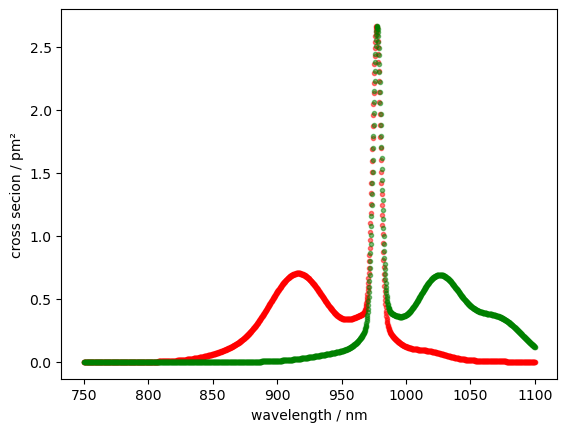

In [3]:
val_matrix = df.to_numpy()

wavelength_values = val_matrix[:,0]*1e-9
abs_cs_values = val_matrix[:,1]*1e24
em_cs_values = val_matrix[:,2]*1e24

print(wavelength_values)
print(abs_cs_values)
print(em_cs_values)

fig0 = plt.figure()
ax0 = fig0.add_subplot(111)
ax0.plot(wavelength_values*1e9,abs_cs_values,'.',color='red',alpha=0.5)
ax0.plot(wavelength_values*1e9,em_cs_values,'.',color='green',alpha=0.5)
ax0.set_xlabel('wavelength / nm')
ax0.set_ylabel('cross secion / pm²')

Set the fitting variables and some parameter, e.g. which wavelength (~omega0) should be the Taylor series expanded

In [9]:
c = 299792458.0 #m/s

# Gauss function with center wavelength and width parameters given in nm, but evaluated in frquency domain
def Gauss(x, amplitude,center,width):
    freq_axis = c / x
    f0 = c / center
    d_f = m.fabs( (c/(center-width/2.0)) -(c/(center+width/2.0)))
    scaling = (2.0*m.sqrt(2.0*m.log(2.0)))
    return amplitude*np.exp(-0.5*(freq_axis-f0)**2/(d_f*scaling)**2)


# Define the Gauss fit function
def Multi_Gauss(x, **params):
    # x is wavelength in nm
    y = np.zeros(x.shape[0],dtype=float)

    parnames = sorted(params.keys())    
    peak_no = int(len(params)/3)    
    
    for k in range(peak_no):
        amp = params[parnames[k]]
        cent = params[parnames[peak_no+k]]
        width = params[parnames[2*peak_no+k]]
        y += Gauss(x,amp,cent,width)

    return y

_TaylorFit = Model(Multi_Gauss)

Now the actual fitting for the absorption cross section

C:\Users\Tom\AppData\Local\Temp\ipykernel_23036\4171587923.py:55: RuntimeWarning: divide by zero encountered in log10
  bx0.plot(oversampled_x,10*np.log10(y),color="b",alpha=0.3)


Text(0, 0.5, 'cross section / pm²')

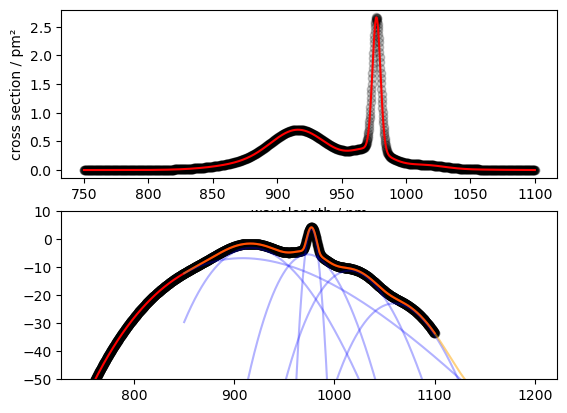

In [13]:
# Parameter names and starting values
params_abs = Parameters()
params_abs.add('a1', value=2.0,min = 1e-3)
params_abs.add('c1', value=977.0, min=850.0,max=1100.0)
params_abs.add('w1', value=1.0,min = 0.1)

params_abs.add('a2', value=0.3,min = 1e-3)
params_abs.add('c2', value=912.0, min=850.0,max=1100.0)
params_abs.add('w2', value=6.0,min = 0.1)

params_abs.add('a3', value=0.4,min = 1e-3)
params_abs.add('c3', value=929.0, min=850.0,max=1100.0)
params_abs.add('w3', value=19.0,min = 0.1)

params_abs.add('a4', value=0.1,min = 1e-3)
params_abs.add('c4', value=973.0, min=850.0,max=1100.0)
params_abs.add('w4', value=4.0,min = 0.1)

params_abs.add('a5', value=0.065,min = 1e-5)
params_abs.add('c5', value=1014.0, min=850.0,max=1100.0)
params_abs.add('w5', value=7.0,min = 1.0)

params_abs.add('a6', value=0.005,min = 1e-5)
params_abs.add('c6', value=1064.0, min=850.0,max=1100.0)
params_abs.add('w6', value=5.0,min = 1.0)


X = wavelength_values*1e9 # now in nm

out_abs = _TaylorFit.fit(abs_cs_values, params_abs, x=X)

fig0 = plt.figure()
ax0 = fig0.add_subplot(211)
bx0 = fig0.add_subplot(212)
ax0.plot(X,abs_cs_values,'o',color='black',alpha=0.2)
ax0.plot(X,out_abs.best_fit,color='red',alpha=1)
bx0.plot(X,10*np.log10(abs_cs_values),'o',color='black',alpha=0.5)
bx0.plot(X,10*np.log10(out_abs.best_fit),color='red',alpha=1)

parnames_abs = sorted(out_abs.params.keys())    
peak_no_abs = int(len(out_abs.params)/3)    
    
scaling = (2.0*m.sqrt(2.0*m.log(2.0)))

oversampled_x = np.linspace(850.0,1200.0,2000)
yo =np.zeros_like(oversampled_x)

for k in range(peak_no_abs):
    amp = out_abs.params[parnames_abs[k]]
    cent = out_abs.params[parnames_abs[peak_no_abs+k]]
    width = out_abs.params[parnames_abs[2*peak_no_abs+k]]

    y=Gauss(oversampled_x,amp,cent,width)
    yo+=y
    bx0.plot(oversampled_x,10*np.log10(y),color="b",alpha=0.3)

bx0.set_ylim([-50, 10])
bx0.plot(oversampled_x,10*np.log10(yo),color='orange',alpha=0.5)

ax0.set_xlabel('wavelength / nm')
ax0.set_ylabel('cross section / pm²')

final values for fiberdesk, units for "a" are pm², "c" and "w" in nm

In [12]:
print('')
parnames = sorted(out_abs.params.keys())
for n, pname in enumerate(parnames):    
    print(pname,' = ',out_abs.params[pname].value)


a1  =  2.3147127296872947
a2  =  0.49661707454004744
a3  =  0.21161394091400842
a4  =  0.2889179335621367
a5  =  0.07554277843619028
a6  =  0.005115164170201747
c1  =  977.0542542813683
c2  =  917.030538984481
c3  =  908.3573045043513
c4  =  973.1153081363955
c5  =  1014.9946691527211
c6  =  1059.5370849738465
w1  =  1.3053270791508669
w2  =  8.782818412801552
w3  =  16.685985573743046
w4  =  5.924240604991774
w5  =  6.798581933571662
w6  =  7.252541456478559
